## Customer-Data-Analytics-and-Engagements
Aim: Analysis of the drivers behind customers engagement
Data Source: IBM datasets: WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv

- Systmes and libraries setup
- Data Load
- Exploratory Analysis
  - Customer engagements
  - Customer segmentations
- Analytics for Customers Engagement
  - Variables encoding
  - Outliers
  - Regressions
  - Decision Trees

In [37]:
# Systems and libraries setup

# import data structure libaries
import pandas as pd
import numpy as np

# import decision model libraries
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz


# import statistical and hypothesis testing libraries
from scipy import stats
import statsmodels.api as sm


# import visualisations libraries
import matplotlib.pyplot as plt

#set fiqure size to control all plt plottings
plt.rcParams['figure.figsize']=(10,7)


In [2]:
#Data Load

m_df = pd.read_csv('WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv') # make skip row =0 so that you can see the headlines

print(m_df.shape)
m_df.head(2)   # print sample frame by rows



(9134, 24)


,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize


## Exploratory Analysis
- Customer engagement response
- Customer base segmentations

Response
No     7826
Yes    1308
Name: Customer, dtype: int64


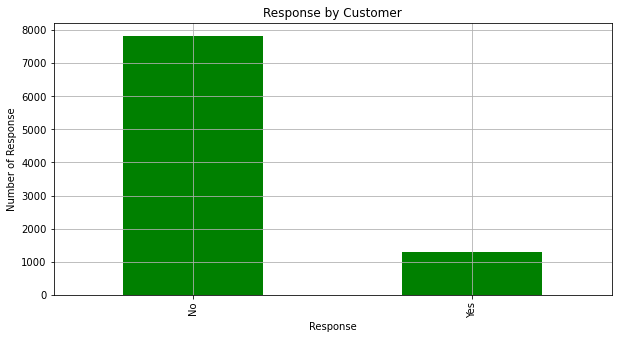

In [3]:
# overall customer engagement response

cust_response = m_df.groupby('Response').count()['Customer']
print(cust_response)

# visualisation
ax= cust_response.plot(
kind = 'bar', color = 'green', grid = True, figsize = (10,5), title = 'Response by Customer')
ax.set_xlabel('Response')
ax.set_ylabel('Number of Response')
plt.show()

In [4]:
# Customer engagement response ( yes or no) by percentage

engaged_m_df = pd.DataFrame(m_df.groupby('Response').count()['Customer'] / m_df.shape[0]*100.0)
print(engaged_m_df)

           Customer
Response           
No        85.679877
Yes       14.320123


Renew Offer Type
Offer1    0.158316
Offer2    0.233766
Offer3    0.020950
Offer4         NaN
Name: Customer, dtype: float64


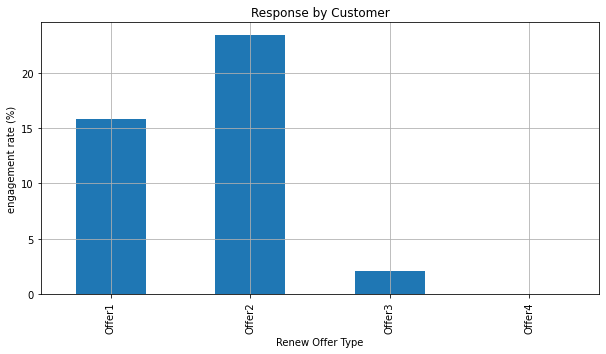

In [6]:
# Customer engagement by Offer type

cust_offer = m_df.loc[m_df['Response'] == 'Yes'].groupby(
    ['Renew Offer Type']).count()['Customer']/m_df.groupby('Renew Offer Type').count(
)['Customer']

print(cust_offer)

# visualisation
ax= (cust_offer*100.0).plot(
kind = 'bar', grid = True, figsize = (10,5), title = 'Response by Customer')
#ax.set_xlabel('Renew Offer Type')
ax.set_ylabel('engagement rate (%)')
plt.show()

Vehicle Class     Four-Door Car  Luxury Car  Luxury SUV       SUV  Sports Car  \
Renew Offer Type                                                                
Offer1                 0.070362    0.001599    0.004797  0.044776    0.011194   
Offer2                 0.114833    0.002051    0.004101  0.041012    0.016405   
Offer3                 0.016760    0.000000    0.000000  0.000000    0.000000   

Vehicle Class     Two-Door Car  
Renew Offer Type                
Offer1                0.025586  
Offer2                0.055366  
Offer3                0.004190  


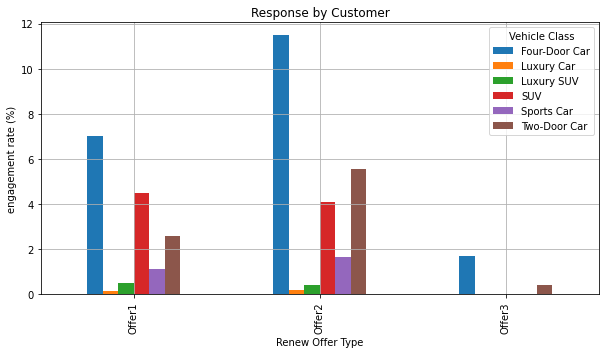

In [7]:
# Customer Response from offer and policy

cust_by_offer_vehicle_class = m_df.loc[m_df['Response'] == 'Yes'].groupby(
    ['Renew Offer Type', 'Vehicle Class']).count()['Customer']/m_df.groupby('Renew Offer Type').count(
)['Customer']

# unstack the format
cust_by_offer_vehicle_class = cust_by_offer_vehicle_class.unstack().fillna(0)
print(cust_by_offer_vehicle_class)

# plot
ax= (cust_by_offer_vehicle_class*100.0).plot(
kind = 'bar',grid = True, figsize = (10,5), title = 'Response by Customer')
ax.set_ylabel('engagement rate (%)')
plt.show()

Sales Channel
Agent          0.191544
Branch         0.114531
Call Center    0.108782
Web            0.117736
Name: Customer, dtype: float64


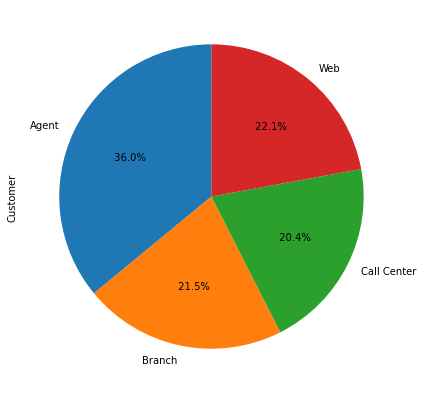

In [8]:
# customer engagement by Sale Channel

cust_by_sale_channel =  m_df.loc[m_df['Response'] == 'Yes'].groupby(
    ['Sales Channel']).count()['Customer']/m_df.groupby('Sales Channel').count(
)['Customer']
print(cust_by_sale_channel)

#plot
(cust_by_sale_channel *360).plot(
    kind = 'pie', figsize =(17,7), startangle = 90, subplots = 'True',
    autopct = lambda x: '% 0.1f%%' % x)
plt.show()

Vehicle Size      Large   Medsize     Small
Sales Channel                              
Agent          0.020708  0.144953  0.025884
Branch         0.021036  0.074795  0.018699
Call Center    0.013598  0.067989  0.027195
Web            0.013585  0.095094  0.009057


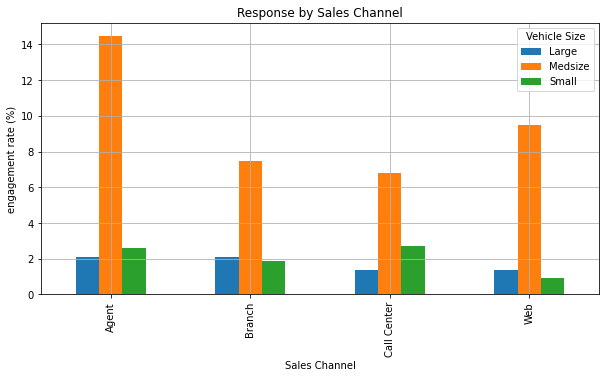

In [9]:
# Engagement by Sales Channel and Vehicle Class

cust_by_schannel_vehicle_size = m_df.loc[m_df['Response'] == 'Yes'].groupby(
    ['Sales Channel', 'Vehicle Size']).count()['Customer']/m_df.groupby('Sales Channel').count(
)['Customer']


# unstack the format
cust_by_schannel_vehicle_size = cust_by_schannel_vehicle_size.unstack().fillna(0)
print(cust_by_schannel_vehicle_size)

# plot
ax= (cust_by_schannel_vehicle_size*100.0).plot(
kind = 'bar', grid = True, figsize = (10,5), title = 'Response by Sales Channel')
ax.set_ylabel('engagement rate (%)')
plt.show()

In [10]:
# Customer base segmentation by Customer Lifetime Value

# 'Customer Lifetime Value' median
median_CLV = m_df['Customer Lifetime Value'].median()
print('Customer Lifetime Value median: {}'.format(median_CLV))

# segmentation
m_df['CLV Segment'] = m_df['Customer Lifetime Value'].apply(
    lambda x: 'High' if x > median_CLV else 'Low'
)

# visualing segments from the first 3 samples
m_df['CLV Segment'].head(3)

Customer Lifetime Value median: 5780.182197


0     Low
1    High
2    High
Name: CLV Segment, dtype: object

In [11]:
# Customer base segmentation by Month Since Policy Inception

# 'Month Since Policy Inception' median
median_MSPI = m_df['Months Since Policy Inception'].median()
print('Months Since Policy Inception median: {}'.format(median_MSPI))

# segmentation
m_df['MSPI Segment'] = m_df['Months Since Policy Inception'].apply(
    lambda x: 'High' if x > median_MSPI else 'Low'
)

# visualing segments from the first 3 samples
m_df['MSPI Segment'].head(3)


Months Since Policy Inception median: 48.0


0    Low
1    Low
2    Low
Name: MSPI Segment, dtype: object

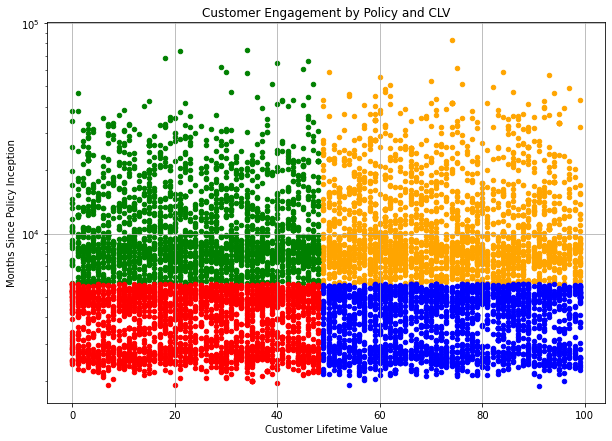

In [12]:
# segment visualisations

# high high segment
ax =  m_df.loc[(m_df['CLV Segment'] == 'High') & (m_df['MSPI Segment'] == 'High')
              ].plot.scatter(
    x = 'Months Since Policy Inception', y = 'Customer Lifetime Value', logy = True, color = 'orange'
)


# low high segment
ax =  m_df.loc[(m_df['CLV Segment'] == 'Low') & (m_df['MSPI Segment'] == 'High')
              ].plot.scatter(
    ax = ax,
    x = 'Months Since Policy Inception', y = 'Customer Lifetime Value', logy = True, color = 'blue'
)


# high low segment
ax =  m_df.loc[(m_df['CLV Segment'] == 'High') & (m_df['MSPI Segment'] == 'Low')
              ].plot.scatter(
    ax = ax,
    x = 'Months Since Policy Inception', y = 'Customer Lifetime Value', logy = True, color = 'green'
)


# low low segment
ax =  m_df.loc[(m_df['CLV Segment'] == 'Low') & (m_df['MSPI Segment'] == 'Low')
              ].plot.scatter( 
    ax = ax,
    x = 'Months Since Policy Inception', y = 'Customer Lifetime Value', logy = True, color = 'red',
    grid = True
    
)

ax.set_ylabel('Months Since Policy Inception')
ax.set_xlabel('Customer Lifetime Value')
ax.set_title('Customer Engagement by Policy and CLV')
plt.show()

MSPI Segment      High       Low
CLV Segment                     
High          0.138728  0.132067
Low           0.162450  0.139957


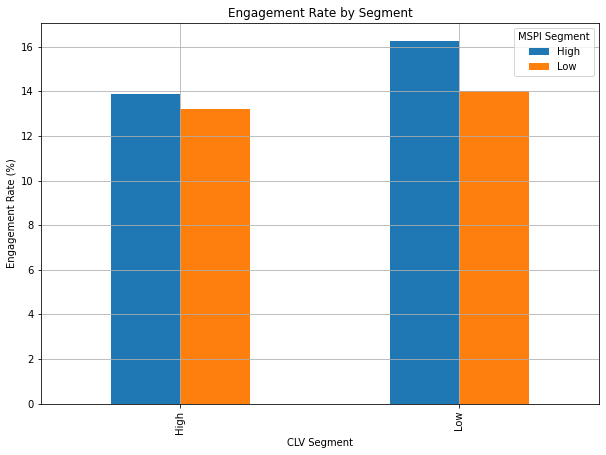

In [14]:
# Customer Engagement by 'CLV Segment' and 'MSPI Segment'

engagement_by_segments = m_df.loc[m_df['Response'] == 'Yes'].groupby(
    ['CLV Segment', 'MSPI Segment']).count()['Customer']/m_df.groupby(['CLV Segment', 'MSPI Segment']).count(
)['Customer']

# unstack the format
engagement_by_segments = engagement_by_segments.unstack().fillna(0)
print(engagement_by_segments)

# plot
ax= (engagement_by_segments*100.0).plot(
kind = 'bar', grid = True, figsize = (10,7), title = 'Engagement Rate by Segment')
ax.set_ylabel('Engagement Rate (%)')
plt.show()



## Analytics for Customers Engagement
- variables and encodings
- Descriptive Statistics
- Linear Regression Analysis
- Decision Tree Analysis

In [47]:
# Response to Engagement encoding using lambda
# Response yes = 1, response no = 0

m_df['engagement'] = m_df['Response'].apply(lambda x: 0 if x == 'No' else 1)
m_df.head(2)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,CLV Segment,MSPI Segment,engagement
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize,Low,Low,0
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize,High,Low,0


In [16]:
# continous variables
cont_var = m_df.describe().columns
print(cont_var)

# category variables
cat_var = m_df.drop(cont_var, axis =1)
cat_var.columns

Index(['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount',
       'engagement'],
      dtype='object')


Index(['Customer', 'State', 'Response', 'Coverage', 'Education',
       'Effective To Date', 'EmploymentStatus', 'Gender', 'Location Code',
       'Marital Status', 'Policy Type', 'Policy', 'Renew Offer Type',
       'Sales Channel', 'Vehicle Class', 'Vehicle Size', 'CLV Segment',
       'MSPI Segment'],
      dtype='object')

In [17]:
# encoding category variables to numeric variables

cols = ['State', 'Coverage', 'Education',
       'Effective To Date', 'EmploymentStatus', 'Gender', 'Location Code',
       'Marital Status', 'Policy Type', 'Policy', 'Renew Offer Type',
       'Sales Channel', 'Vehicle Class', 'Vehicle Size'] 

cat_vars = []

for i in cols:
    x, y = m_df[i].factorize()
    x_var = x
    cat_vars.append(x_var)

cat_vars_df = pd.DataFrame(cat_vars)
cat_vars_df = cat_vars_df.T.rename(columns = {0:'State', 1:'Coverage', 2:'Education', 3: 'Effective To Date',
                                   4:'EmploymentStatus', 5:'Gender', 6:'Location Code',
                                   7:'Marital Status', 8: 'Policy Type', 9: 'Policy', 10:'Renew Offer Type',
                                   11:'Sales Channel', 12:'Vehicle Class', 13: 'Vehicle Size' })

# drop previous cols
m_df1 = m_df.drop(cols, axis = 1)
m_df1 = pd.concat([m_df1,cat_vars_df], axis = 1)

print(m_df1.shape)
print(m_df.shape)
m_df1.columns

(9134, 27)
(9134, 27)


Index(['Customer', 'Customer Lifetime Value', 'Response', 'Income',
       'Monthly Premium Auto', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Total Claim Amount', 'CLV Segment',
       'MSPI Segment', 'engagement', 'State', 'Coverage', 'Education',
       'Effective To Date', 'EmploymentStatus', 'Gender', 'Location Code',
       'Marital Status', 'Policy Type', 'Policy', 'Renew Offer Type',
       'Sales Channel', 'Vehicle Class', 'Vehicle Size'],
      dtype='object')

In [18]:
# Drop Response variable
m_df2 = m_df1.drop('Response', axis = 1)
print(m_df2.shape)
print(m_df2.columns)

# Descriptive Statistics
m_df2.describe()

# explanation:
# different variables have different mean and std,
# for predictive solution for instance, requires normalisation to mean 0 and std 1
# the interqaurtile range can also be visualised to see if there is any outlier in the data

(9134, 26)
Index(['Customer', 'Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount',
       'CLV Segment', 'MSPI Segment', 'engagement', 'State', 'Coverage',
       'Education', 'Effective To Date', 'EmploymentStatus', 'Gender',
       'Location Code', 'Marital Status', 'Policy Type', 'Policy',
       'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size'],
      dtype='object')


,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,engagement,State,...,EmploymentStatus,Gender,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,...,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794,0.143201,2.553208,...,0.604773,0.490037,0.540508,0.569849,0.825925,2.755091,1.133786,1.326473,1.260784,0.400263
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092,0.350297,1.309185,...,0.985009,0.499928,0.771247,0.738200,0.475989,2.300418,1.077858,1.242362,1.085465,0.668760
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839,0.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,2.000000,3.000000,2.000000,1.000000
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678,1.000000,4.000000,...,4.000000,1.000000,2.000000,2.000000,2.000000,8.000000,3.000000,3.000000,5.000000,2.000000


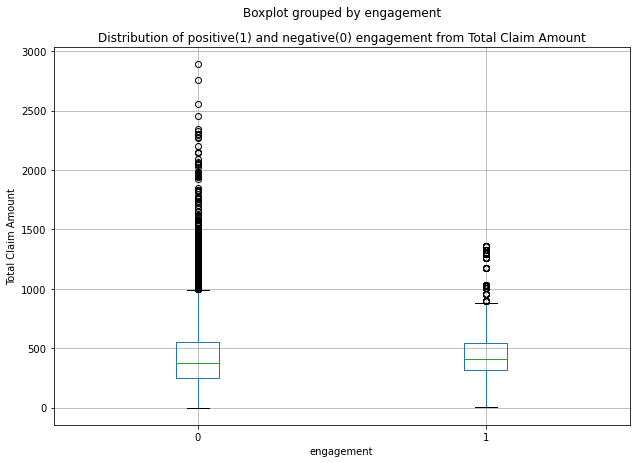

In [19]:
# univariate outlier checks with boxplot and 'Total Claim Amount' variable

ax = m_df2[['engagement', 'Total Claim Amount']].boxplot(
    by = 'engagement', showfliers = True, figsize = (10,7)
    )
ax.set_xlabel('engagement')
ax.set_ylabel('Total Claim Amount')
ax.set_title('Distribution of positive(1) and negative(0) engagement from Total Claim Amount')
plt.show()

# explanation:
# Outliers are suspected outside the interquartile range, indicated by dots marks
# the quartile sizes are not the same, indicating a non-uniform distribution of outcome variables

In [20]:
# Linear Regression Analysis
cols_r = ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount',
       'State', 'Coverage', 'Education', 'Effective To Date',
       'EmploymentStatus', 'Gender', 'Location Code', 'Marital Status',
       'Policy Type', 'Policy', 'Renew Offer Type', 'Sales Channel',
       'Vehicle Class', 'Vehicle Size']

# fitting
logist = sm.Logit(
    m_df2['engagement'].astype(float), m_df2[cols_r].astype(float)
)

# model fitting
logist_fit = logist.fit()

# model summary
logist_fit.summary()

# explanation:
# assumption: pvalue at 0.05 signicance for null hypothesis (H0)
# The H0 have a strong relationship between independent and response(outcome) variable when pvalue is less than 0.05
# Independent variables including 'Income','Monthly Premium Auto','Months Since Last Claim'
# and 'Months Since Policy Inception' for instance have strong relationship with the outcome variable 'engagement'
# H0 is therefore accepted while rejecting the alternate hypothesis(H1)

Optimization terminated successfully.
         Current function value: 0.382748
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             engagement   No. Observations:                 9134
Model:                          Logit   Df Residuals:                     9112
Method:                           MLE   Df Model:                           21
Date:                Wed, 20 Jan 2021   Pseudo R-squ.:                 0.06813
Time:                        10:43:00   Log-Likelihood:                -3496.0
converged:                       True   LL-Null:                       -3751.6
Covariance Type:            nonrobust   LLR p-value:                 6.649e-95
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Customer Lifetime Value        -6.36e-06   5.19e-06     -1.225      0.221   -1.65e-05    3.81e-06
Income                         1.236e-05   1.26e-06      9.842      0.000     9.9e-06    1.48e-05
Monthly Premium Auto             -0.0052      0.002     -2.761      0.006      -0.009      -0.002
Months Since Last Claim          -0.0119      0.003     -3.935      0.000      -0.018      -0.006
Months Since Policy Inception    -0.0035      0.001     -3.287      0.001      -0.006      -0.001
Number of Open Complaints        -0.0637      0.035     -1.808      0.071      -0.133       0.005
Number of Policies               -0.0542      0.013     -4.097      0.000      -0.080      -0.028
Total Claim Amount               -0.0009      0.000     -4.511      0.000      -0.001      -0.000
State                            -0.0683      0.022     -3.079      0.002      -0.112      -0.025
Coverage                          0.1429      0.061      2.353      0.019       0.024       0.262
Education                        -0.0452      0.024     -1.897      0.058      -0.092       0.001
Effective To Date                -0.0130      0.002     -7.315      0.000      -0.016      -0.009
EmploymentStatus                  0.4527      0.029     15.504      0.000       0.395       0.510
Gender                           -0.0926      0.061     -1.508      0.132      -0.213       0.028
Location Code                    -0.6914      0.060    -11.490      0.000      -0.809      -0.573
Marital Status                    0.1556      0.040      3.911      0.000       0.078       0.234
Policy Type                      -0.2231      0.067     -3.327      0.001      -0.354      -0.092
Policy                            0.0009      0.014      0.060      0.952      -0.027       0.029
Renew Offer Type                 -0.0741      0.030     -2.489      0.013      -0.132      -0.016
Sales Channel                    -0.2491      0.026     -9.722      0.000      -0.299      -0.199
Vehicle Class                     0.1932      0.044      4.341      0.000       0.106       0.280
Vehicle Size                     -0.0772      0.047     -1.646      0.100      -0.169       0.015
=================================================================================================
"""

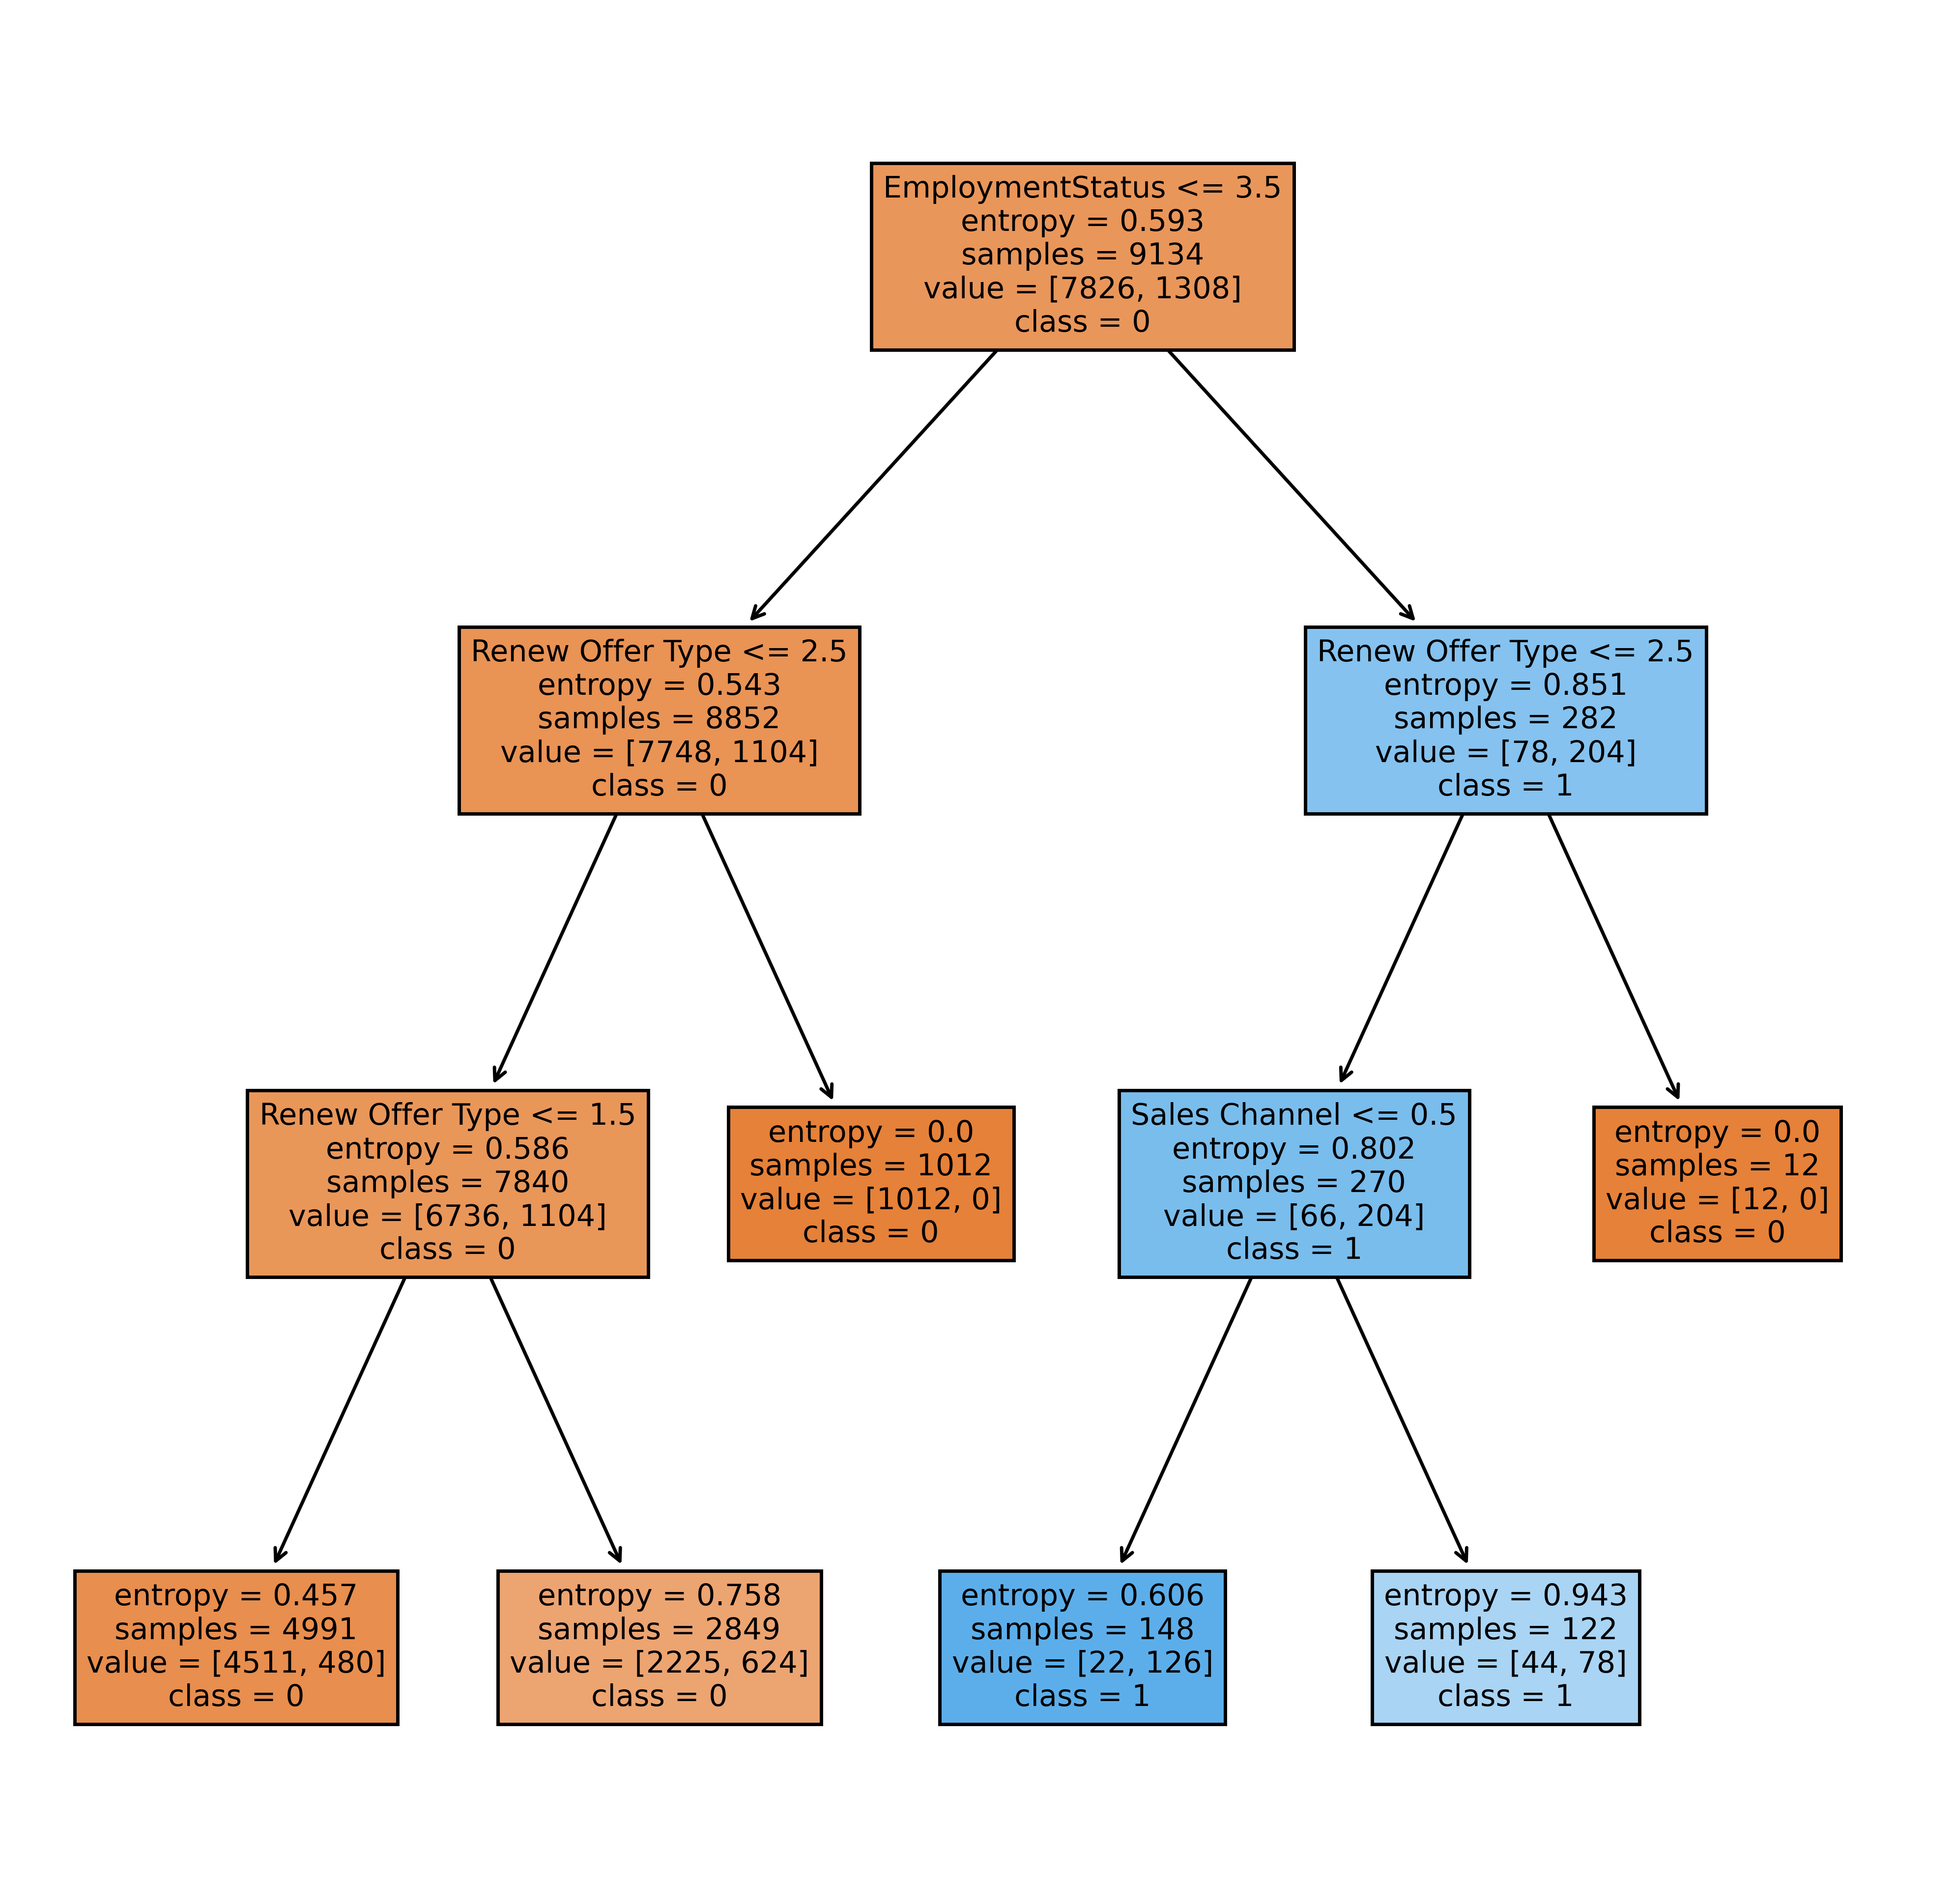

In [88]:
# Decision Tree Analysis

dt_model = tree.DecisionTreeClassifier(
    max_depth = 3, 
    criterion = 'entropy',
    splitter = 'best',   # best variable with the highest coefficient
    min_samples_split = 2
)

# fit the built model

dt_model_fit = dt_model.fit(
    m_df2[cols_r].astype(float), m_df2['engagement'].astype(float) 
)


# output visualisation
fig, axes = plt.subplots(nrows = 1, ncols = 1,figsize = (10,10), dpi=500)
tree.plot_tree(dt_model_fit,
               feature_names = cols_r, 
               class_names=['0', '1'],
               filled = True);
fig.savefig('Features_split.jpg')


# tree split explanation:
# navigating tree nodes for a decision making(class: yes-1 or no-0) by spliting a node and terminating a leaf
# node selection controlled by entropy, node split controlled by information gain
# with +ve information gain tree node grows and -ve information gain tree node terminate
# Here, with a max level of tree depth(3): 
# EmploymentStatus variable had high entropy with 9134 training samples, and was selected as root node
# The root node was sampled for information gain with 9134 samples, Renew Offer Type was selected for splitting
# Renew Offer Type variable had L-8852 and R -282 samples as child nodes with 2 +ve information gains for further splitting
# Further sampling of R- 282 produced 2 nodes L-270 and R-12 with L having +ve gain and R terminate because no +ve gain found
# This continues untill all the training data size are sampled or the end of the tree is reached